# Búsqueda Tabú

Se implementará la versión de BT utilizando una lista de movimientos tabú y tres estrategias de reinicialización.Sus principales características son:
* Estrategia de selección de vecino: Consistirá en examinar 40 vecinos para cogerel mejor de acuerdo a los criterios tabú.
* Selección  de  estrategias  de reinicialización:  La  probabilidad  de  escoger  lareinicialización construyendo una solución inicial aleatoria es 0,25, la de usar lamemoria a largo plazo al generar una nueva solución greedy es 0,5, y la deutilizar la reinicialización desde la mejor solución obtenidaes 0,25.
* Además de saltar a una solución concreta según las reinicializaciones comentadas, también  se  alterará  un  parámetro  del  algoritmo  de  búsqueda  para  provocar  un cambio de comportamiento del algoritmo más efectivo. Este consistirá en variar el tamaño de la lista tabú, incrementándola o reduciéndola en un 50% según una decisión aleatoria uniforme. 
 
El número máximo de iteraciones en total, incluyendo las reinicializaciones, será de 40 · n. Se realizarán 4 reinicializaciones, es decir, una cada 8 · n iteraciones.  

El tamaño inicial   de   cada   lista   tabú   será n=2,   estos   valores   cambiarán   después   de   las reinicializaciones según se ha comentado.Dado el carácter probabilístico del algoritmo, deberá ejecutarse 10 veces (con semillas distintas para el generador aleatorio, para cada caso del problema (dataset).

---
## Librerías
- matplotlib: necesaria para la representación de la solución.
- pandas: necesaria para la representación de resultados.
- random: necesaria para el control de números aleatorios.
- datetime: necesaria para la obtención de una semilla inicial que genere las demás semillas.
- multiprocessing: necesaria para la ejecución concurrente de las soluciones.
- itertools: necesaria para combinar las semillas con los dataset en la ejecución concurrente.
- ipynb: necesaria para cargar la función busqueda_aleatorio de otro fichero. Esto permite la ejecución concurrente en Jupyter.

In [31]:
from matplotlib import pyplot as plt
import pandas as pd
from random import seed
from random import randint
from datetime import datetime
from multiprocessing import Pool, TimeoutError
import itertools
from ipynb.fs.full.algoritmo import busqueda_tabu

---
## Funciones auxiliares
- cargar_fichero(nombre_fichero): devuelve un array con las ciudades almacenadas en el fichero. [ [ ciudad, posición x , posición y ] [...] ... ]
- calcular_distancia_euclidea(node_1,node_2): devuelve en la distancia entre las dos ciudades.
- dibujar_flecha(A, B): dibuja una flecha entre el punto A y B apuntando a B. 
- representacion(camino, nombre, distancia): representa las ciudades y el camino calculado.
- representacion_datos(result,nombre): representa la solución obtenida de la ejecución concurrente de un dataset.

In [32]:
def cargar_fichero(nombre_fichero):
    
    fichero = open( "../Dataset/" + nombre_fichero + ".tsp", 'r')
    
    for i in range(3):
        fichero.readline()
        
    numero_de_ciudades = fichero.readline().strip().split()[1]
    
    for i in range(2):
        fichero.readline()
        
    ciudades = []
    for i in range(0, int(numero_de_ciudades)):
        ciudad,x,y = fichero.readline().strip().split()[:]
        ciudades.append([int(ciudad),float(x),float(y)])  
        
    fichero.close()
    
    return ciudades

In [33]:
def calcular_distancia_euclidea(ciudad_1,ciudad_2):
    
    x1,y1 = ciudad_1[1 :]
    x2,y2 = ciudad_2[1 :]
    
    xd = x1 - x2
    yd = y1 - y2
    
    return round(math.sqrt( xd*xd + yd*yd ))

In [34]:
def dibujar_flecha(A, B):
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
              head_width=1.3, length_includes_head=True)

In [35]:
def representacion(camino, nombre, distancia):
    
    plt.figure(figsize=(10,10))
    
    for i in range(len(camino)):
        if(i == 0):
            plt.plot(camino[i][1], camino[i][2] , "o", color="green")
        else:
            plt.plot(camino[i][1], camino[i][2] , "*", color="red")
        
        if(i<len(camino)-1):
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[i+1][1], camino[i+1][2]])
        else:
            dibujar_flecha([camino[i][1], camino[i][2]],[camino[0][1], camino[0][2]])
    
    plt.title(nombre + " : " + str(distancia))

In [36]:
def representacion_datos(result,nombre):
    semilla_coste = pd.DataFrame(columns=["Semilla","Coste","Nº de evaluaciones"])
    for i in range(10):


        semilla_coste.loc[len(semilla_coste)] = [semillas[i],result[i][1], result[i][2]]
    display(semilla_coste)

    print("Media coste: ", semilla_coste[['Coste']].mean()[0])
    print("Desviación típica coste: ", semilla_coste[['Coste']].std()[0])
    print("Media nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].mean()[0])
    print("Desviación típica nº de evaluaciones: ", semilla_coste[['Nº de evaluaciones']].std()[0])


    print()
    print("Representación de la mejor solución: ")
    indice = semilla_coste[['Coste']].idxmin()[0]


    representacion(result[indice][0], nombre, result[indice][1])

---
## Función de evaluación
Esta función genera el coste total de la solución pasara por parámetro. Para ello recorre todas las ciudades de la solución sumando el coste entre ellas. 

In [37]:
def funcion_de_evaluacion(solucion):
    coste = 0
    for indice in range(len(solucion)-1):
        coste += calcular_distancia_euclidea(solucion[indice],solucion[indice+1])
    coste += calcular_distancia_euclidea(solucion[-1],solucion[0])
    return coste

---
## Lectura de ficheros y ejecución del algoritmo
Para poder ejecutar correctamente el algoritmo de forma concurrente en Jupyter, este debe ser cargado de forma externa. Para ello se ha usado la librería ipynb.

In [38]:
st70 = cargar_fichero("st70")
ch130 = cargar_fichero("ch130")
a280 = cargar_fichero("a280")
p654 = cargar_fichero("p654")
vm1084 = cargar_fichero("vm1084")
vm1748 = cargar_fichero("vm1748")

### Generación de semillas

In [39]:
semillas = []
dt = datetime.now()
for i in range(10):
    semillas.append(randint(0,dt.microsecond))
print("Semillas generadas:")
print(semillas)

Semillas generadas:
[300541, 321738, 73331, 362058, 99299, 149895, 26006, 31309, 565565, 2817]


#### st70

,Semilla,Coste,Nº de evaluaciones
0,300541.0,997.0,112001.0
1,321738.0,1020.0,112001.0
2,73331.0,1030.0,112001.0
3,362058.0,1004.0,112001.0
4,99299.0,1040.0,112001.0
5,149895.0,1065.0,112001.0
6,26006.0,1028.0,112001.0
7,31309.0,1007.0,112001.0
8,565565.0,1037.0,112001.0
9,2817.0,976.0,112001.0


Media coste:  1020.4
Desviación típica coste:  25.31227194684648
Media nº de evaluaciones:  112001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


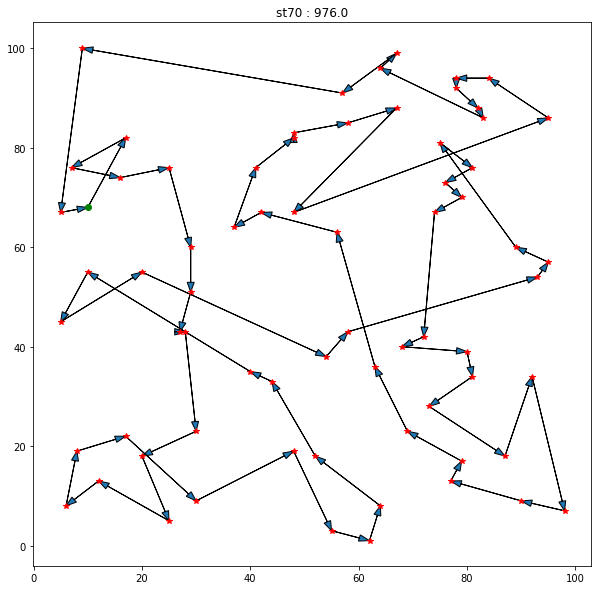

In [40]:
dataset = st70
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
representacion_datos(result,"st70")

#### ch130


,Semilla,Coste,Nº de evaluaciones
0,300541.0,12594.0,208001.0
1,321738.0,11785.0,208001.0
2,73331.0,12709.0,208001.0
3,362058.0,12152.0,208001.0
4,99299.0,12697.0,208001.0
5,149895.0,11281.0,208001.0
6,26006.0,12537.0,208001.0
7,31309.0,11727.0,208001.0
8,565565.0,12689.0,208001.0
9,2817.0,11836.0,208001.0


Media coste:  12200.7
Desviación típica coste:  515.2481710571885
Media nº de evaluaciones:  208001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


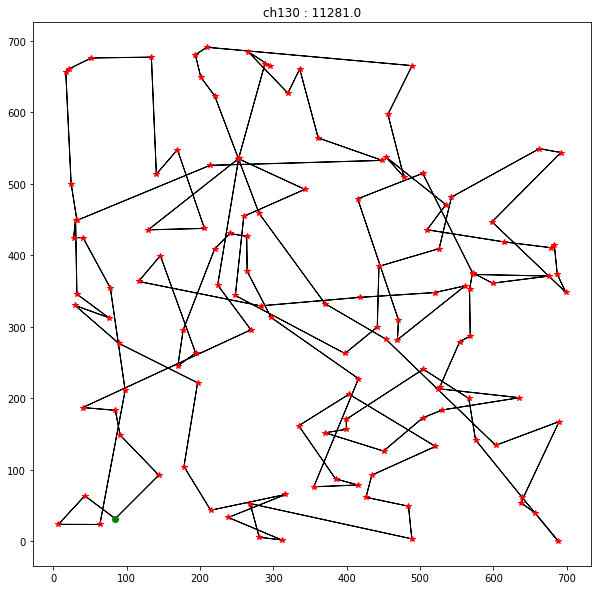

In [41]:
dataset = ch130

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"ch130")

#### a280

,Semilla,Coste,Nº de evaluaciones
0,300541.0,3574.0,448001.0
1,321738.0,4327.0,448001.0
2,73331.0,3226.0,448001.0
3,362058.0,3288.0,448001.0
4,99299.0,3096.0,448001.0
5,149895.0,3054.0,448001.0
6,26006.0,3403.0,448001.0
7,31309.0,3554.0,448001.0
8,565565.0,3550.0,448001.0
9,2817.0,3333.0,448001.0


Media coste:  3440.5
Desviación típica coste:  361.9190363726242
Media nº de evaluaciones:  448001.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


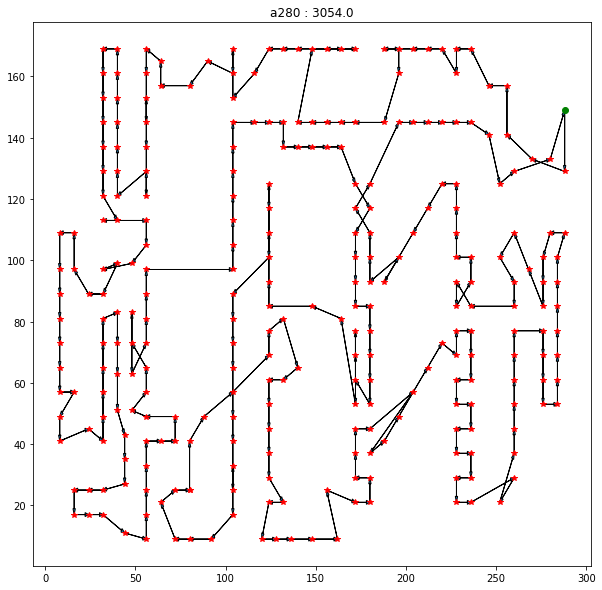

In [42]:
dataset = a280
with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )

representacion_datos(result,"a280")

#### p654

,Semilla,Coste,Nº de evaluaciones
0,300541.0,108897.0,1046401.0
1,321738.0,124494.0,1046401.0
2,73331.0,108634.0,1046401.0
3,362058.0,110048.0,1046401.0
4,99299.0,109085.0,1046401.0
5,149895.0,114863.0,1046401.0
6,26006.0,109380.0,1046401.0
7,31309.0,112558.0,1046401.0
8,565565.0,121263.0,1046401.0
9,2817.0,115424.0,1046401.0


Media coste:  113464.6
Desviación típica coste:  5585.845965971095
Media nº de evaluaciones:  1046401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


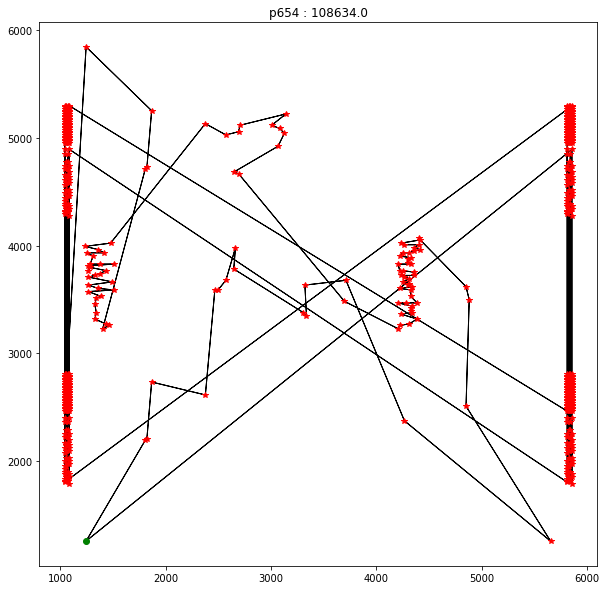

In [43]:
dataset = p654

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"p654")

#### vm1084

,Semilla,Coste,Nº de evaluaciones
0,300541.0,1745942.0,1734401.0
1,321738.0,1795398.0,1734401.0
2,73331.0,1833422.0,1734401.0
3,362058.0,1892437.0,1734401.0
4,99299.0,1902790.0,1734401.0
5,149895.0,1787836.0,1734401.0
6,26006.0,1920375.0,1734401.0
7,31309.0,1840181.0,1734401.0
8,565565.0,1885702.0,1734401.0
9,2817.0,1803699.0,1734401.0


Media coste:  1840778.2
Desviación típica coste:  57882.42359933914
Media nº de evaluaciones:  1734401.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


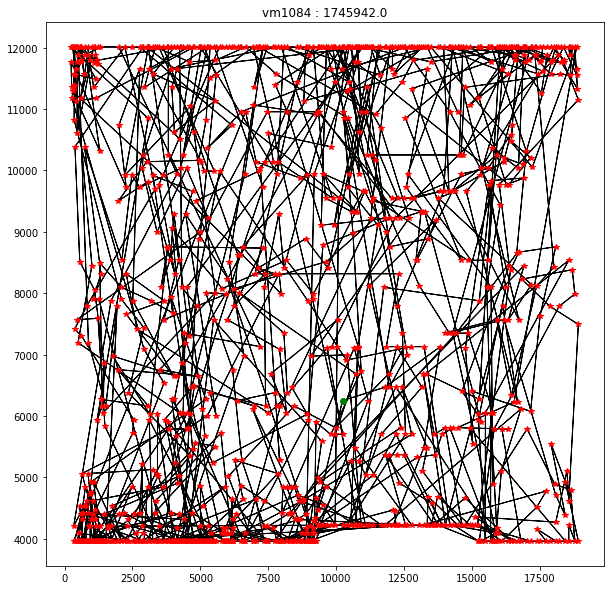

In [44]:
dataset = vm1084

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1084")

#### vm1748

,Semilla,Coste,Nº de evaluaciones
0,300541.0,3390532.0,2796801.0
1,321738.0,3316053.0,2796801.0
2,73331.0,3273503.0,2796801.0
3,362058.0,3270641.0,2796801.0
4,99299.0,3182490.0,2796801.0
5,149895.0,3218187.0,2796801.0
6,26006.0,3099204.0,2796801.0
7,31309.0,3259047.0,2796801.0
8,565565.0,3243019.0,2796801.0
9,2817.0,3211985.0,2796801.0


Media coste:  3246466.1
Desviación típica coste:  78067.36600234726
Media nº de evaluaciones:  2796801.0
Desviación típica nº de evaluaciones:  0.0

Representación de la mejor solución: 


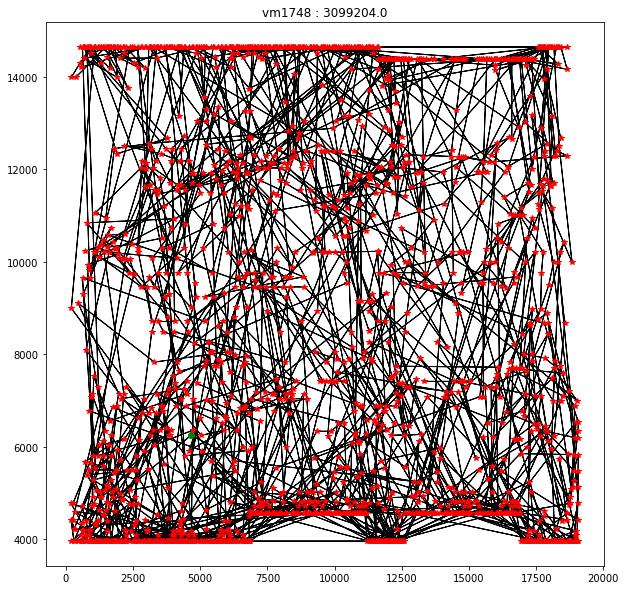

In [45]:
dataset = vm1748

with Pool(processes=5) as pool:
    result = pool.starmap(busqueda_tabu,  itertools.product(semillas,[dataset],[40]) )
    
representacion_datos(result,"vm1748")